In [2]:
%load_ext autoreload

# Reading libraries....
import ASMElib
import importlib

from ASMElib import * 
importlib.reload(ASMElib)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 재료:  SS316H (ASME에는 TP316H라 표시됨. SS316과는 다름)
#Pm: the general primary memberane stress 

In [3]:
Pm = float(input("Pm 값을 입력하세요. 단위 (MPa): "))
PL = float(input("PL 값을 입력하세요. 단위 (MPa): "))
Pb = float(input("Pb 값을 입력하세요. 단위 (MPa): "))

Pm 값을 입력하세요. 단위 (MPa):  50
PL 값을 입력하세요. 단위 (MPa):  50
Pb 값을 입력하세요. 단위 (MPa):  50


In [5]:
# Test Case (Given)
Pm = 50 
PL = 60 
Pb = 60

# Design Limit 

In [6]:
# 판단 기준
# [입력값] Pm, PL, Pb
# [설계 조건]  
# Pm (<=) So 
# PL+Pb (<=) 1.5 * So

# [1단계] So 결정하기
# So: the maximum allowable value of general primary membrane stress intensity 
# (참고)So 결정할 때, 저온의 경우 Smt까지 고려해서 결정해야함. (56page)

So=determine_So("./data/TP316H_So.csv")
print(f"테이블에서 읽은 So 값: {So:.2f} MPa")


# [2단계] 설계점 평가 

if(Pm <= So):
    print("Design Limit Condition (a) is passed.")
else:
    print("Design Limit Condition (a) is failed.")
    
# (b) (Pl+Pb) <= 1.5 *So 
if( (PL+Pb) <= 1.5 *So ):
    print("Design Limit Condition (b) is passed.")
else:
    print("Design Limit Condition (b) is failed.")

FileNotFoundError: [Errno 2] No such file or directory: './data/TP316H_So.csv'

# Level A and Level B Service Limit

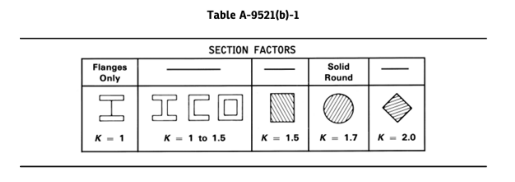

섹션 형상에 맞는 K값을 입력하세요. (참고: Shell-Type 구조의 벽면 Stress를 평가하는 경우 K=1.5를 입력)


 1


The value of K is  1.0
The value of Kt is  1.0
   Temperature [°C]  Time [h]
0             425.0        20
1             450.0        30
2             475.0        10
3             650.0        20


In [14]:

# 판단 기준
# [입력값] Pm, PL, Pb
# [설계 조건]  
# Pm (<=) Smt 
# PL+Pb (<=) K * Sm 
# PL+Pb/Kt (<=) St

# K: the section factor for the cross section 
# Kt: accounts for the reduction in extream fiber bending stress due to the effect of creep 

# K is given by section shape, and Kt = (K+1)/2

K,Kt=determine_K_and_Kt()
print("The value of K is ", K)
print("The value of Kt is ", Kt)


# 사용자로부터 시간, 히스토리를 입력받아야함. 
# [User INPUT- OCT]
# [시작온도, 끝 온도, time 구간]

segments = [
    (300, 600, 30),  # 기울기형 구간
    (600, 700, 20),  # 계단형 구간
    (500, 450, 10),
    (400,450, 20)
]

Tt_ListForSmt =extract_Tt_list_for_Smt(segments, mode="mid")

print(Tt_ListForSmt)




In [15]:

'''
img = mpimg.imread('./images/SmReductionRatio.png')
plt.imshow(img)
plt.axis('off')  # 축 없애기
plt.show()

print("섹션 형상에 맞는 K값을 입력하세요. (참고: Shell-Type 구조의 벽면 Stress를 평가하는 경우 K=1.5를 입력)")

K= float(input())
Kt= (K+1.0)/2.0

print("The value of K is ", K)
print("The value of Kt is ", Kt)
'''


'\nimg = mpimg.imread(\'./images/SmReductionRatio.png\')\nplt.imshow(img)\nplt.axis(\'off\')  # 축 없애기\nplt.show()\n\nprint("섹션 형상에 맞는 K값을 입력하세요. (참고: Shell-Type 구조의 벽면 Stress를 평가하는 경우 K=1.5를 입력)")\n\nK= float(input())\nKt= (K+1.0)/2.0\n\nprint("The value of K is ", K)\nprint("The value of Kt is ", Kt)\n'

# Level A Limit 
## Based on Linearly Elastic Material Model Analysis

In [16]:
import pandas as pd
import numpy as np
from tabulate import tabulate

# CSV 읽기
df = pd.read_csv("Smt1.csv", encoding="utf-8-sig")

# 첫 열을 온도로 설정
df = df.rename(columns={"Unnamed: 0": "온도"})
df = df.set_index("온도")
df.columns = df.columns.astype(float)   # 시간축을 숫자로 변환

# (시간, 온도) → Smt 계산 함수
def get_smt(time_val, temp_val):
    times = df.columns.values
    temps = df.index.values

    # ----- 시간 구간 찾기 -----
    right_idx = np.searchsorted(times, time_val, side="left")
    if right_idx == 0:
        time_low, time_high = times[0], times[1]
    elif right_idx >= len(times):
        time_low, time_high = times[-2], times[-1]
    else:
        time_low, time_high = times[right_idx-1], times[right_idx]

    # ----- 온도 보간 (time_low) -----
    smt_lowT = np.interp(temp_val, [temps.min(), temps.max()],
                         [df.loc[temps.min(), time_low], df.loc[temps.max(), time_low]])

    # ----- 온도 보간 (time_high) -----
    smt_highT = np.interp(temp_val, [temps.min(), temps.max()],
                          [df.loc[temps.min(), time_high], df.loc[temps.max(), time_high]])

    # ----- 시간 보간 -----
    smt_val = np.interp(time_val, [time_low, time_high], [smt_lowT, smt_highT])
    return smt_val

# ===== (시간, 온도) 리스트 추출 =====
Tt_ListForSmt = extract_Tt_list_for_Smt(segments, mode="mid")  

# ===== (시간, 온도) → Smt 계산 후 DataFrame 생성 =====
results = []
for idx, row in Tt_ListForSmt.iterrows():
    t = row["Time [h]"]
    temp = row["Temperature [°C]"]
    smt = get_smt(t, temp)
    results.append((idx+1, t, temp, round(smt, 2)))  # 소수점 2자리

results_df = pd.DataFrame(results, columns=["세그먼트", "시간[h]", "온도[°C]", "Smt"])

# ===== 콘솔에 표 출력 =====
print(tabulate(results_df, headers="keys", tablefmt="pretty", showindex=False))


+----------+---------+----------+--------+
| 세그먼트 | 시간[h] | 온도[°C] |  Smt   |
+----------+---------+----------+--------+
|   1.0    |  20.0   |  425.0   | 110.0  |
|   2.0    |  30.0   |  450.0   | 104.8  |
|   3.0    |  10.0   |  475.0   | 100.67 |
|   4.0    |  20.0   |  650.0   |  65.6  |
+----------+---------+----------+--------+
